## Census Data

In [146]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import folium
from folium import GeoJson, Marker

In [147]:
df = pd.read_csv('census_1km.csv', sep = ';')
df = df.drop(axis = 1, columns = ["Gitter_ID_1km *"])
df.head()

,x_mp_1km_1,y_mp_1km_1,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D
0,4314500,3367500,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0
1,4331500,3372500,3,-9.0,0.0,100.0,0.00,-1.0,-1.0,-9.0,-1.0
2,4315500,3378500,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0
3,4316500,3379500,3,-9.0,0.0,0.0,100.00,-1.0,-1.0,-1.0,-1.0
4,4335500,3379500,7,-9.0,-9.0,0.0,57.14,1.4,-1.0,-1.0,-1.0


In [148]:
# create geometry element from point coordinates
geometry = gpd.points_from_xy(df.x_mp_1km_1, df.y_mp_1km_1, crs="EPSG:3035")

# create new geopandas dataframe dropping old columns
gdf = gpd.GeoDataFrame(df, geometry = geometry)
gdf = gdf.drop(columns = ['x_mp_1km_1','y_mp_1km_1'])

gdf = gdf.to_crs(4326)
gdf.head(3)

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,geometry
0,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.90225 53.41535)
1,3,-9.0,0.0,100.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (10.15807 53.46022)
2,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.91710 53.51421)


<AxesSubplot: >

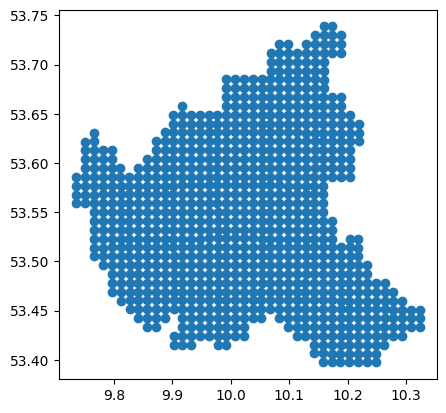

In [149]:
gdf.plot()

In [150]:
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y
points_gdf = gdf[['lon', 'lat']]
def create_box(centroid):
    side_length = 0.008983112  # Seitenlänge der Box in Grad (~1 km in Breitengraden für EPSG:4326)
    return centroid.buffer(side_length/2).envelope

# 1 km x 1 km-Box für jeden Centroid erstellen
gdf['bbox'] = gdf['geometry'].apply(lambda x: create_box(x))

# Mittelpunkt für Kartenansicht berechnen
center_lat, center_lon = points_gdf['lat'].mean(), points_gdf['lon'].mean()
points_gdf.head(1)

,lon,lat
0,9.902253,53.415355


In [151]:
m = folium.Map(location=[center_lat, center_lon], zoom_start=14, tiles='cartodb positron')

# GeoJSON für Punkte und Boxen erstellen
points_geojson = GeoJson(points_gdf.to_json())
boxes_geojson = GeoJson(gdf['bbox'].to_json())

# GeoJSON zur Karte hinzufügen
points_geojson.add_to(m)
boxes_geojson.add_to(m)

# Optional: Achsentitel hinzufügen
folium.Marker([center_lat, center_lon], popup='Centroid').add_to(m)
m

In [152]:
gdf_centroid = gdf["geometry"]
gdf_bbox = gdf["bbox"]
gdf_bbox.head()

0    POLYGON ((9.89776 53.41086, 9.90674 53.41086, ...
1    POLYGON ((10.15357 53.45573, 10.16256 53.45573...
2    POLYGON ((9.91261 53.50972, 9.92159 53.50972, ...
3    POLYGON ((9.92767 53.51872, 9.93665 53.51872, ...
4    POLYGON ((10.21411 53.51854, 10.22309 53.51854...
Name: bbox, dtype: geometry

In [153]:
gdf_centroid.to_file('census_centroid_data.json', driver ='GeoJSON')
gdf_bbox.to_file('census_bbox_data.json', driver ='GeoJSON')